In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy.integrate as inte
from numpy import matmul as mm
from mpl_toolkits import mplot3d

In [2]:
def quad_pos(pos,rot,L,H=.05):
    tmp = np.hstack((rot,pos))
    wHb = np.vstack((tmp,np.array([0,0,0,1])))
    quadBodyFrame = np.array([[L,0,0,1],
                             [0,L,0,1],
                             [-L,0,0,1],
                             [0,-L,0,1],
                             [0,0,0,1],
                             [0,0,H,1]]).T
    quadWorldFrame = mm(wHb,quadBodyFrame)
    quad = quadWorldFrame[:3,:]
    return quad
def QuatToRot(q):
    q = q/np.sqrt(np.sum(q**2))
    qahat = np.zeros((3,3))
    qahat[0,1],qahat[0,2] = -q[3],q[2]
    qahat[1,2],qahat[1,0] = -q[1],q[3]
    qahat[2,0],qahat[2,1] = -q[2],q[1]
    R = np.eye(3)+2*mm(qahat,qahat)+2*q[0]*qahat
    return R
def simStateToQuadState(sim_state):
    quad_state = np.zeros((13,1))
    quad_state[:2] = 0; quad_state[3:5] = 0
    quad_state[7:] = 0; quad_state[6] = 1
    quad_state[2] = sim_state[0];
    quad_state[5] = sim_state[1]
    return quad_state
def sys_eom(t,s,controlhandle,trajhandle,params):
    s_des = trajhandle(t)
    u_des = controlhandle(s,s_des,params)
    u_clamped = np.clip(u_des,params['u_min'],params['u_max'])
    sdot = np.array([[s[1]],[u_clamped/params['mass']-params['gravity']]])
    return sdot
def sys_params_limit_thrust():
    params = {}
    params['gravity'],params['mass'],params['arm_length']=9.81,.18,.086
    params['u_min'] = 0
    params['u_max'] = 1.2*params['mass']*params['gravity']
    return params

In [3]:
def controller(s,s_des,params):
    Kp, Kv = 4500, 400
    e = s_des[0]-s[0]; de = s_des[1]-s[1]
    d2z = 0
    u = params['mass']*(d2z+Kp*e+Kv*de+params['gravity'])
    return u
def fixed_set_point(t,z_des):
    if t == 0:
        s_des = np.array([[0],[0]])
    else:
        s_des = np.array([[z_des],[0]])
    return s_des

In [4]:
class QuadPlot():
    def __init__(self,qn,state,wingspan,height,color,max_iter,h_3d=None):
        # public
        self.k,self.time = 0,0
        self.qn = qn
        self.state = state
        self.wingspan = wingspan
        self.color = color
        self.height = height
        self.rot = QuatToRot(self.state[6:10])
        self.motor = quad_pos(self.state[:3],self.rot,self.wingspan,self.height)
        self.max_iter = max_iter
        self.state_hist = np.zeros((6,max_iter))
        self.time_hist = np.zeros((1,max_iter))
        
        # private
        self.__text_dist = self.wingspan/3
        if h_3d is None:
            h_3d = plt.gca()
        self.__h_3d = h_3d
        self.__h_pos_hist = h_3d.plot3D(self.state[0],
                                        self.state[1],self.state[2],'r.')
        self.__h_m13 = h_3d.plot3D(self.motor[0,[0,2]],
                                  self.motor[1,[0,2]],
                                  self.motor[2,[0,2]],'-ko',
                                  markerfacecolor=self.color,
                                  markersize=5)
        self.__h_m24 = h_3d.plot3D(self.motor[0,[1,3]],
                                  self.motor[1,[1,3]],
                                  self.motor[2,[1,3]],'-ko',
                                  markerfacecolor=self.color,
                                  markersize=5)
        self.__h_qz = h_3d.plot3D(self.motor[0,[4,5]],
                                  self.motor[1,[4,5]],
                                  self.motor[2,[4,5]],
                                  color=self.color,
                                  linewidth=2)
#         self.__h_qn = 
    def UpdateQuadState(self,state,time):
        self.state = state
        self.time = time
        self.rot = QuatToRot(state[6:10]).T
    def UpdateQuadHist(self):
        self.k += 1
        self.time_hist[0,self.k] = self.time
        self.state_hist[:,self.k] = self.state[:6].flatten()
    def UpdateMotorPos(self):
        self.motor = quad_pos(self.state[:3],self.rot,self.wingspan,self.height)
    def TruncateHist(self):
        self.time_hist = self.time_hist[:self.k]
        self.state_hist = self.state_hist[:,:self.k]
    def UpdateQuadPlot(self,state,time):
        self.UpdateQuadState(state,time)
        self.UpdateQuadHist()
        self.UpdateMotorPos()
        h_3d = plt.gca()
        self.__h_pos_hist = h_3d.plot3D(self.state_hist[0,:self.k],
                                        self.state_hist[1,:self.k],
                                        self.state_hist[2,:self.k],'r.')
        self.__h_m13 = h_3d.plot3D(self.motor[0,[0,2]],
                                  self.motor[1,[0,2]],
                                  self.motor[2,[0,2]],'-ko',
                                  markerfacecolor=self.color,
                                  markersize=5)
        self.__h_m24 = h_3d.plot3D(self.motor[0,[1,3]],
                                  self.motor[1,[1,3]],
                                  self.motor[2,[1,3]],'-ko',
                                  markerfacecolor=self.color,
                                  markersize=5)
        self.__h_qz = h_3d.plot3D(self.motor[0,[4,5]],
                                  self.motor[1,[4,5]],
                                  self.motor[2,[4,5]],
                                  color=self.color,
                                  linewidth=2)
        fig = plt.gcf()
        fig.canvas.draw()
        

In [21]:
def height_control(trajhandle,controlhandle):
    params = sys_params_limit_thrust()
    real_time = True
    fig = plt.figure(figsize=(20,10))
    plt.ion()
    fig.show()
    fig.canvas.draw()
    
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.view_init(0,0)
    ax1.set_xlim([-1,1])
    ax1.set_ylim([-1,1])
    ax1.set_zlim([-.5,1.5])
    
    ax2 = fig.add_subplot(122)
    quadcolors = [0,.447,.741]
    
    ## Initial Conditions
    max_iter,starttime,tstep,cstep = 100,0,.01,.05
    nstep = cstep/tstep
    time,des_start,des_stop = starttime,trajhandle(0),trajhandle(np.inf)
    stop_pos,x0,pos_tol,vel_tol = des_stop[0],des_start,.01,.01
    x,xtraj,ttraj=x0,np.nan*np.ones((int(max_iter*nstep),len(x0))),np.nan*np.ones((int(max_iter*nstep),1))
    
    for Iter in range(max_iter):
        timeint = np.arange(time,time+cstep+tstep,tstep)
        
        # Initialize quad plot
        if Iter == 0:
            ax1 = fig.add_subplot(121, projection='3d')
            ax1.view_init(0,0)
            ax1.set_xlim([-1,1])
            ax1.set_ylim([-1,1])
            ax1.set_zlim([-.5,1.5])
            quad_state = simStateToQuadState(x0)
            QP=QuadPlot(1,quad_state,params['arm_length'],.05,
                       quadcolors,max_iter,ax1)
            quad_state = simStateToQuadState(x)
            QP.UpdateQuadPlot(quad_state,time)
            
        
        xsave = np.zeros((len(timeint),len(x0))); xsave[0,:] = x0.flatten()
        r = inte.ode(lambda t,s:sys_eom(t,s,controlhandle,trajhandle,params)).set_integrator("dopri5") 
        r.set_initial_value(x, timeint[0])   # initial values
        for i in range(1, timeint.size):
            xsave[i, :] = r.integrate(timeint[i]).flatten() # get one more value, add it to the array
            if not r.successful():
               raise RuntimeError("Could not integrate")
        
        x = xsave[-1,:].reshape(-1,1)
        xtraj[int((Iter)*nstep):int((Iter+1)*nstep),:] = xsave[-5:,:]
        ttraj[int((Iter)*nstep):int((Iter+1)*nstep)] = timeint[-5:].reshape(-1,1)
        
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.view_init(0,0)
        ax1.set_xlim([-1,1])
        ax1.set_ylim([-1,1])
        ax1.set_zlim([-.5,1.5])
        quad_state = simStateToQuadState(x)
        QP.UpdateQuadPlot(quad_state,time+cstep)
        time += cstep
        
        ax2.clear()
        ax2 = fig.add_subplot(122)
        ax2.plot(ttraj[:int(Iter*nstep)],xtraj[:int(Iter*nstep),0])
        
    t_out = ttraj[:int(Iter*nstep)]
    z_out = xtraj[:int(Iter*nstep),0]

    return t_out,z_out

In [22]:
z_des = 1
trajhandle = lambda t: fixed_set_point(t,z_des)
controlhandle = lambda s,s_des,params: controller(s,s_des,params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<IPython.core.display.Javascript object>


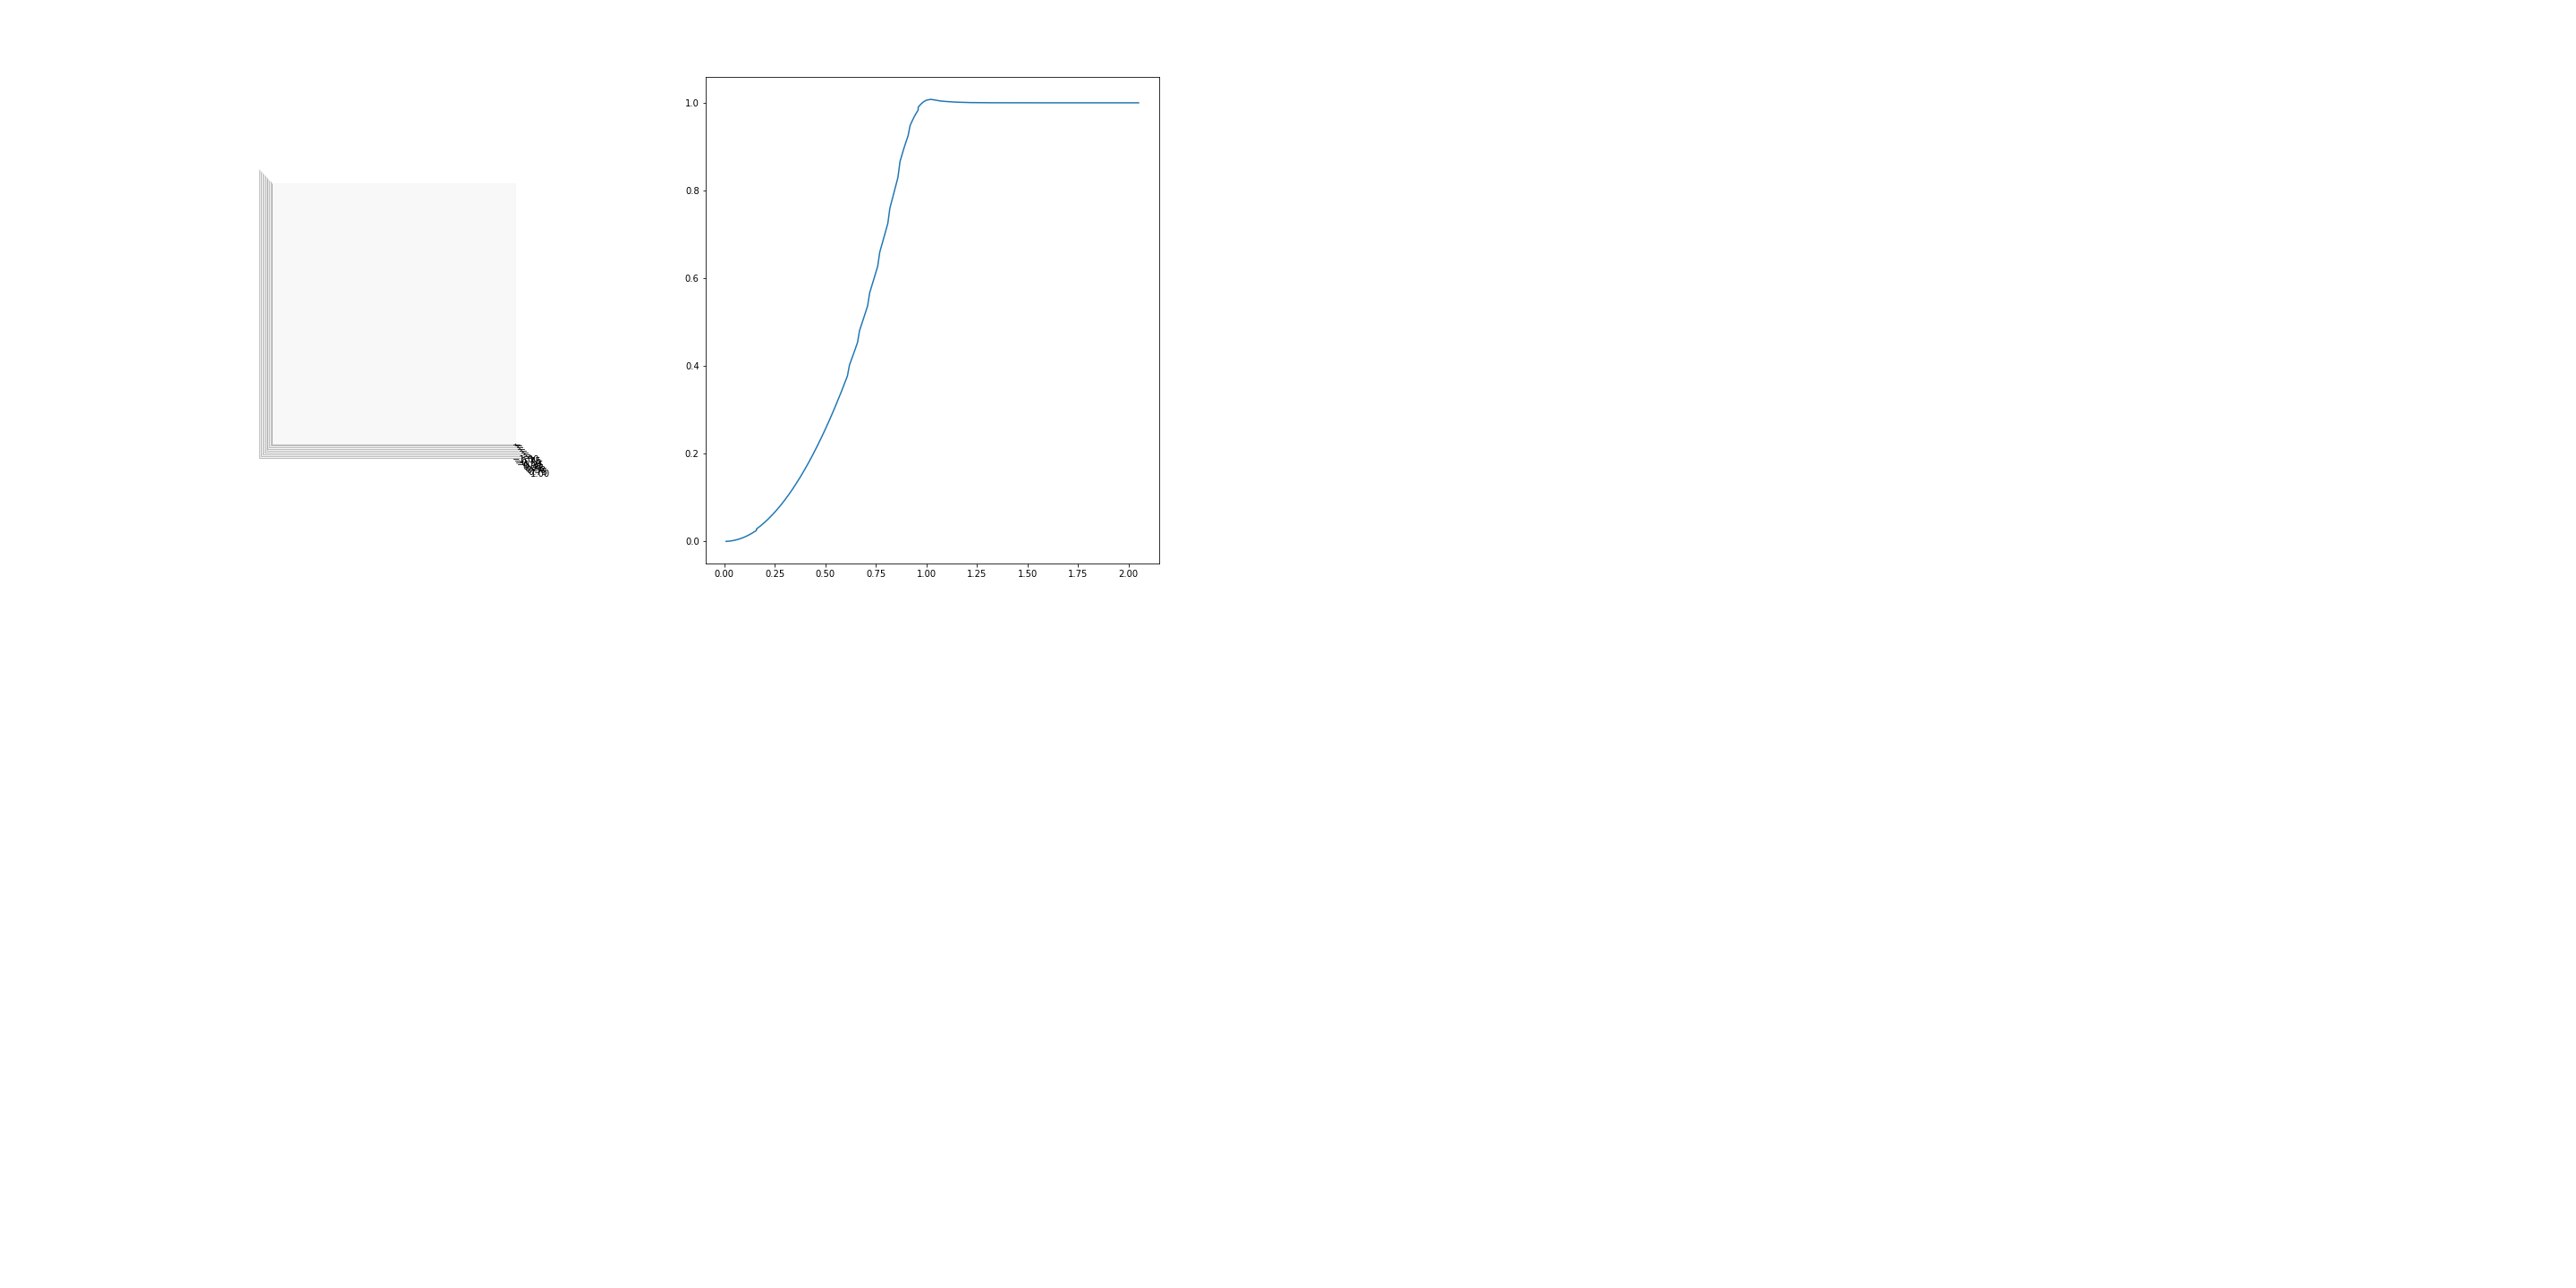

C:\Users\44754\Anaconda3\lib\site-packages\ipykernel_launcher.py:66: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


KeyboardInterrupt: 

In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%matplotlib notebook
t,z = height_control(trajhandle,controlhandle)